# SSBR Baseline

This notebook explore the data and results from training the SSBR model on the IRCAD dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from pathlib import Path
import numpy as np
import json
import os

exp = 'exp3'
exp_root =  Path('../experiments')

## Data sources

### Dataset

We use IRCAD's liver dataset (https://www.ircad.fr/research/3dircadb/) for training a baseline model. This dataset is composed of 20 abdominal CT scans and a number of segmented organs, mainly the liver.

The `IrcadData` is a utility class which downloads and extracts the data. It also provides a mapping between volume_ids and their corresponding dicom folder.

In [25]:
from ssbr.datasets.ircad import IrcadData

ircad_folder = Path('../data/ircad')
ircad = IrcadData(ircad_folder)

for k, v in ircad.items():
    print(f'{k} -{v}')

INFO:IRCAD dataset already downloaded at https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.zip


3Dircadb1.17 -../data/ircad/data/3Dircadb1.17/PATIENT_DICOM
3Dircadb1.4 -../data/ircad/data/3Dircadb1.4/PATIENT_DICOM
3Dircadb1.13 -../data/ircad/data/3Dircadb1.13/PATIENT_DICOM
3Dircadb1.8 -../data/ircad/data/3Dircadb1.8/PATIENT_DICOM
3Dircadb1.2 -../data/ircad/data/3Dircadb1.2/PATIENT_DICOM
3Dircadb1.5 -../data/ircad/data/3Dircadb1.5/PATIENT_DICOM
3Dircadb1.20 -../data/ircad/data/3Dircadb1.20/PATIENT_DICOM
3Dircadb1.3 -../data/ircad/data/3Dircadb1.3/PATIENT_DICOM
3Dircadb1.9 -../data/ircad/data/3Dircadb1.9/PATIENT_DICOM
3Dircadb1.7 -../data/ircad/data/3Dircadb1.7/PATIENT_DICOM
3Dircadb1.16 -../data/ircad/data/3Dircadb1.16/PATIENT_DICOM
3Dircadb1.15 -../data/ircad/data/3Dircadb1.15/PATIENT_DICOM
3Dircadb1.18 -../data/ircad/data/3Dircadb1.18/PATIENT_DICOM
3Dircadb1.14 -../data/ircad/data/3Dircadb1.14/PATIENT_DICOM
3Dircadb1.10 -../data/ircad/data/3Dircadb1.10/PATIENT_DICOM
3Dircadb1.19 -../data/ircad/data/3Dircadb1.19/PATIENT_DICOM
3Dircadb1.6 -../data/ircad/data/3Dircadb1.6/PATIENT_DI


### Data generator

The data source for the SSBR model must provide a 5 dimensional array :

`[BATCH_SIZE, NUM_SLICES, WIDTH, HEIGHT, CHANNEL]`

A sample in this case is a stack of equidistant slices sampled inside the dicom volume. Each image is a 2 dimensional, 3 channel array.

When loading the volumes, a series of volumes transformations are applied before sampling equidistant slices. The transfomed volumes are cached in an HDF5 file to only load slices from disk when needed.

The DicomVolumeStore class provides a mapping between volume_ids and transformed volume (the HDF5 cache interface). This store also manages the split ratio for training and validation.

Finally the SSBRDataset is a generator that yields batches of image stacks.

In [26]:
from ssbr.datasets.utils import DicomVolumeStore, stack_sampler, SSBRDataset
from ssbr.datasets.ops import grey2rgb, resize, rescale, image2np
import h5py

BATCH_SIZE = 4 # The number of image stacks
NUM_SLICES = 8 # The number of equidistant images per stacks

volume_transforms = [
    resize((64, 64)),
    image2np,
    rescale(low=-300, high=700, scale=255, dtype=np.uint8),
    grey2rgb,
]

cache = h5py.File(str(ircad_folder / 'ircad.h5'), 'a')
volumes = DicomVolumeStore(ircad, transforms=volume_transforms, cache=cache)
dataset = SSBRDataset(volumes=volumes, split=0.2)
datagen_train = dataset.train(batch_size=BATCH_SIZE, num_slices=NUM_SLICES)
datagen_valid = dataset.valid(batch_size=BATCH_SIZE, num_slices=NUM_SLICES)

<IPython.core.display.Javascript object>


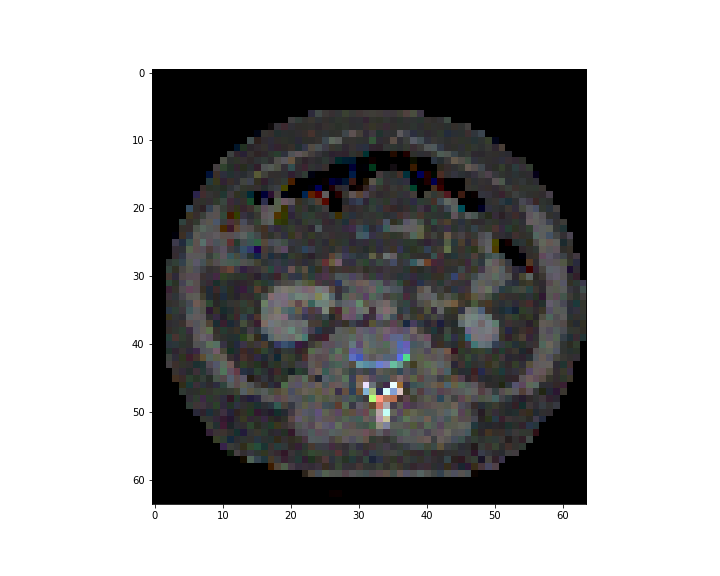

interactive(children=(IntSlider(value=0, description='sli', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.update(sli=IntSlider(value=0, description='sli', max=7))>

In [28]:
%matplotlib notebook
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt

batch, _ = next(datagen_train)
stack = batch[0]

fig = plt.figure(figsize=(10,8))
ax = plt.imshow(stack[0])

slider = widgets.IntSlider(min=0, max=NUM_SLICES-1, step=1, value=0)
def update(sli = slider):
    ax.set_data(stack[sli])

interact(update)


## Model training

The model definition provided by `ssbr_model` provides two entrypoints. The first one, `m`, will be the model for the training procedure which requires an input slice stack. The second one, `score_extractor`, will be used at prediction time for evaluating the score for individual slices.

In [29]:
from ssbr.runners.train import TrainConfig, train_experiment

config = TrainConfig()
dataset = 'ircad'
output = Path('../experiments') / exp
print(config)

TrainConfig(resize=(64, 64), window=(-300, 700), train_valid_split=0.2, equidistance_range=(1, 6), lr=0.0001, batch_size=5, num_slices=8, loss_alpha=0.5, num_epochs=10, steps_per_epoch=30, valid_steps=20)


In [9]:
# Launch the training
train_experiment(config, dataset, output)

INFO:IRCAD dataset already downloaded at https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.zip


Epoch 1/10
30/30 [==============================] - 7s 217ms/step - loss: 13.8392 - loss_order: 25.0046 - loss_distance: 2.6739 - val_loss: 11.8741 - val_loss_order: 23.2134 - val_loss_distance: 0.3744

Epoch 00001: val_loss improved from inf to 11.87405, saving model to ../experiments/exp4/model.h5
Epoch 2/10
30/30 [==============================] - 5s 163ms/step - loss: 11.8590 - loss_order: 23.0082 - loss_distance: 0.7098 - val_loss: 10.8177 - val_loss_order: 21.9939 - val_loss_distance: 0.6623

Epoch 00002: val_loss improved from 11.87405 to 10.81770, saving model to ../experiments/exp4/model.h5
Epoch 3/10
30/30 [==============================] - 5s 159ms/step - loss: 11.4371 - loss_order: 20.7771 - loss_distance: 2.0972 - val_loss: 9.4755 - val_loss_order: 18.5717 - val_loss_distance: 1.3117

Epoch 00003: val_loss improved from 10.81770 to 9.47547, saving model to ../experiments/exp4/model.h5
Epoch 4/10
30/30 [==============================] - 5s 159ms/step - loss: 11.5766 - loss_

<IPython.core.display.Javascript object>


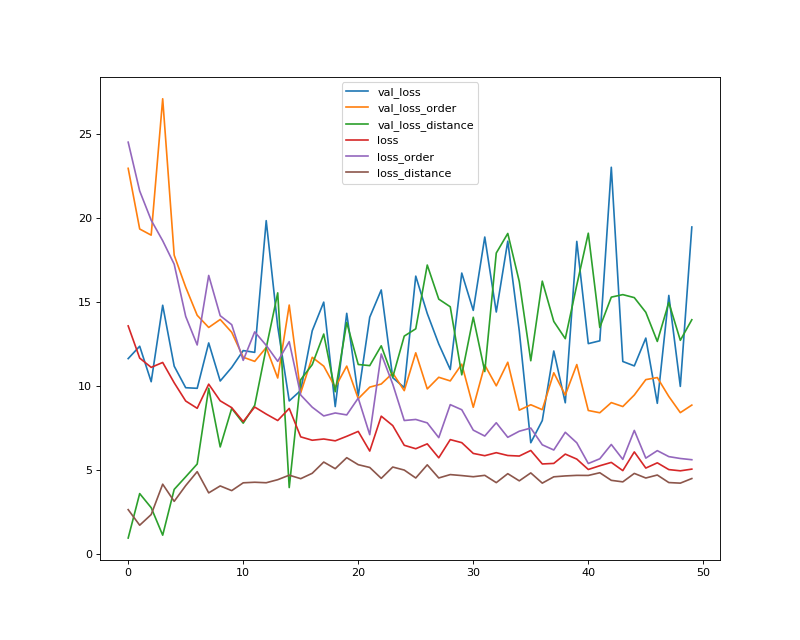

In [30]:
# Plot resulting losses
with open(output / 'history.json', 'r') as fid:
    hist = json.load(fid)

fig = plt.figure(figsize=(10, 8), dpi= 80)
labels = []
for k, v in hist.items():
    labels.append(k)
    plt.plot(v)
plt.legend(labels)
plt.show()

## Results exploration

Let's first evaluate the results of the SSBR model on the data we have. I'm obviously about to do something terrible here and evaluate the score_extractor on all training data. But since each slices are evaluated independently and that I am interestedin the resulting evolution of the score along the axial dimension, it'll do until I add a test dataset (any suggestion?)

In [31]:
from ssbr.datasets.utils import batcher
from ssbr.model import ssbr_model
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

config = {}
m, score_extractor = ssbr_model(lr=config.get('lr', 0.0001),
                                batch_size=5,
                                num_slices=8,
                                alpha=config.get('alpha', 0.5))

exp_folder = exp_root / exp
weights_fp = exp_folder / 'model.h5'

m.load_weights(str(weights_fp))

results = {}
for vid in volumes:
    print(f'Computing results for volume {vid}')
    vol = volumes[vid]
    scores= []
    for batch in batcher(vol, 10):
        sco = score_extractor.predict_on_batch(batch)
        scores.extend(sco)
    results[vid] = np.asarray(scores)


Computing results for volume 3Dircadb1.17
Computing results for volume 3Dircadb1.4
Computing results for volume 3Dircadb1.13
Computing results for volume 3Dircadb1.8
Computing results for volume 3Dircadb1.2
Computing results for volume 3Dircadb1.5
Computing results for volume 3Dircadb1.20
Computing results for volume 3Dircadb1.3
Computing results for volume 3Dircadb1.9
Computing results for volume 3Dircadb1.7
Computing results for volume 3Dircadb1.16
Computing results for volume 3Dircadb1.15
Computing results for volume 3Dircadb1.18
Computing results for volume 3Dircadb1.14
Computing results for volume 3Dircadb1.10
Computing results for volume 3Dircadb1.19
Computing results for volume 3Dircadb1.6
Computing results for volume 3Dircadb1.1
Computing results for volume 3Dircadb1.12
Computing results for volume 3Dircadb1.11


### Scores

The first thing to explore are the evolution of the score along the axial axis. For each volume, the score will ideally be as linear as possible, indicating that the model can correctly predict the anatomical location of a slice in the axial direction. Depending on body type and variations, this slope will be more or less slanted and jagged.

Text(0, 0.5, 'SSBR score (unitless)')

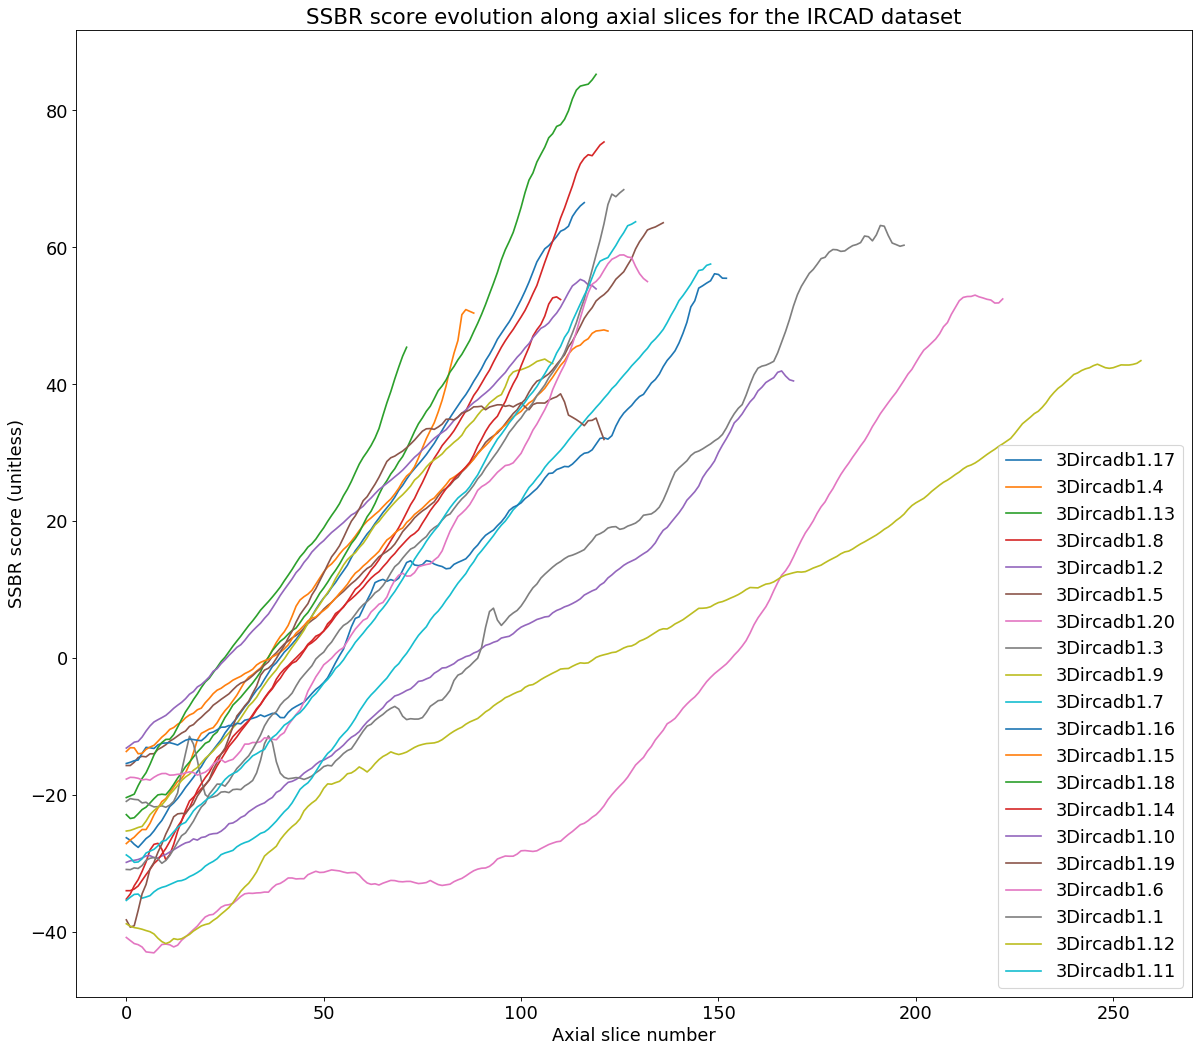

In [32]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
vids = []
for vid, val in results.items():
    plt.plot(val)
    vids.append(vid)
plt.legend(vids, loc='lower right')
plt.title('SSBR score evolution along axial slices for the IRCAD dataset')
plt.xlabel('Axial slice number')
plt.ylabel('SSBR score (unitless)')

Second, let's plot those value against a coronal view of the data, so we can identify if similar scores indeed plot against similar anatomical locations

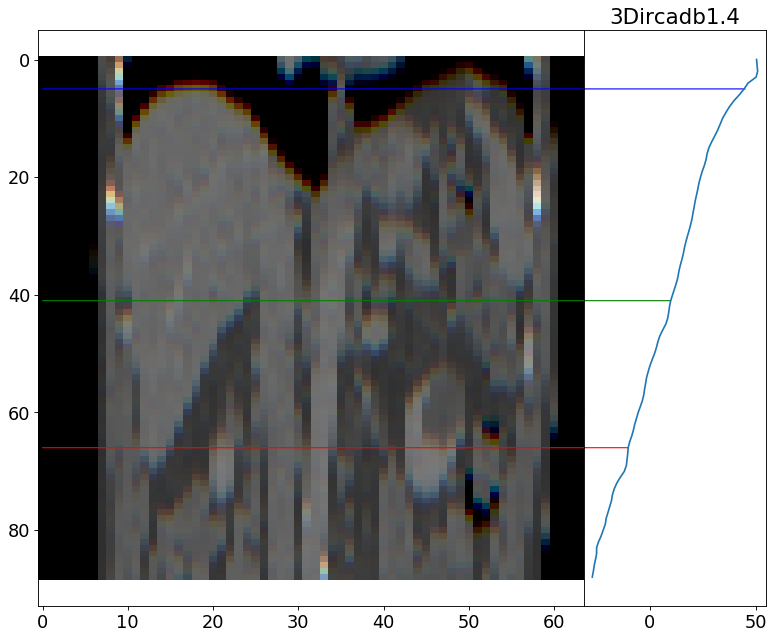

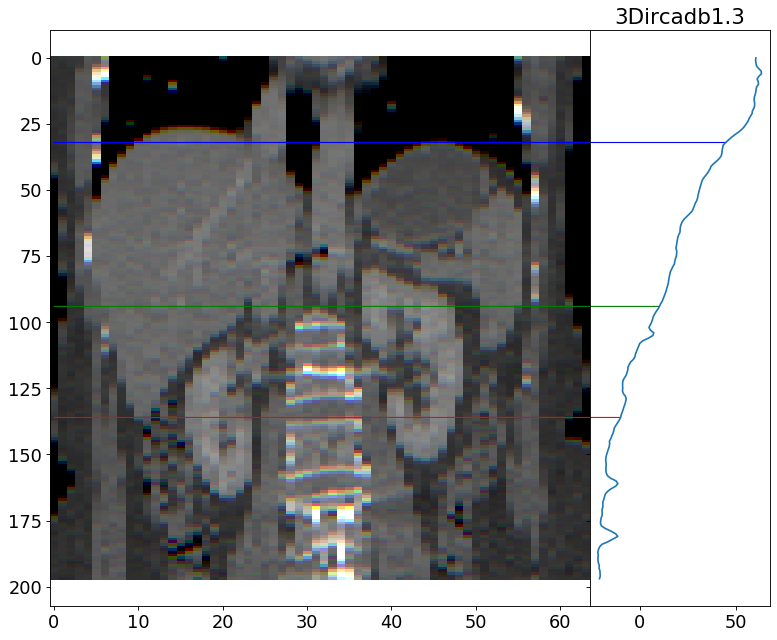

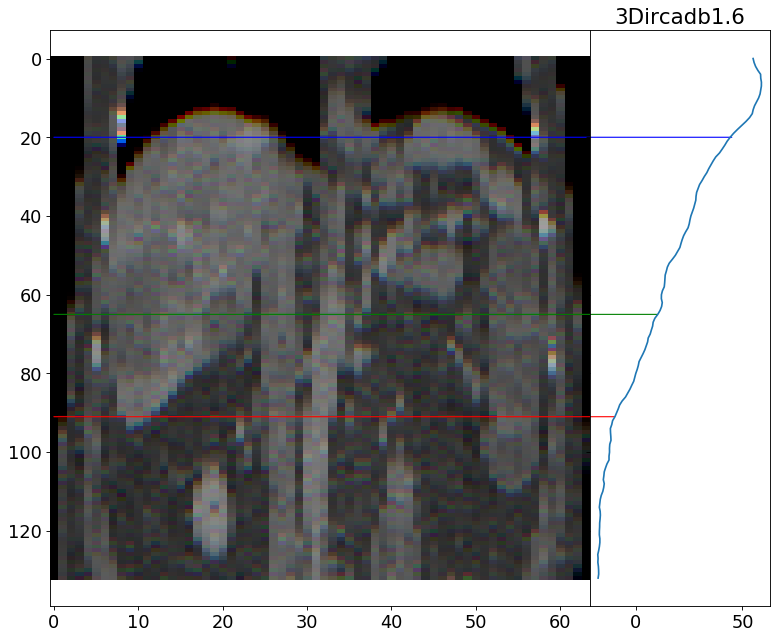

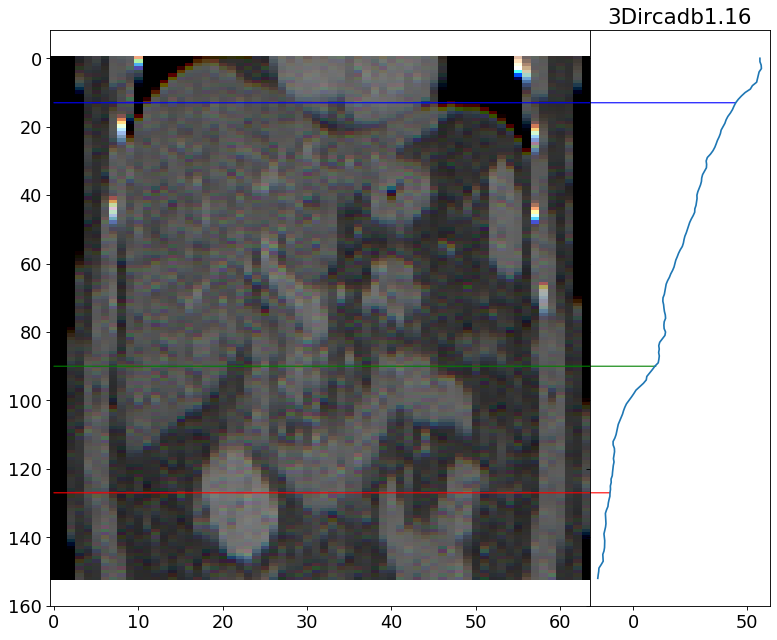

In [33]:
from matplotlib.patches import ConnectionPatch
from itertools import cycle

itemsiter = iter(volumes.items())

split_fp = exp_folder / 'split.json'

with open(split_fp,'r') as fid:
    split = json.load(fid)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for vid in split['valid']:
    vol = volumes[vid]
    
    fig = plt.figure(figsize=(10, 8), dpi= 80)

    vol_np = np.asarray(vol)
    shp = vol_np.shape
    img_coro = np.flipud(np.squeeze(vol_np[:, shp[1] // 2, :]))
    
    scores = results[vid]
    revscores=scores[::-1]
    
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 4), (0, 3), sharey=ax1)

    ax1.imshow(img_coro, cmap='gray', aspect='auto')
    ax2.plot(revscores, np.arange(len(revscores)))

    # Add a horizontal line
    colors = cycle(iter(['blue', 'red', 'green']))
    for target in [45, -10, 10]:    
        idx = find_nearest(revscores, target)
        xyA = (target, idx)
        xyB = (0, idx)
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color=next(colors))
        ax2.add_artist(con)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.title(vid)
    